In [1]:
using Pkg; Pkg.activate()

using LinearAlgebra
using Plots

using Revise
using CarbonNetworks

In [2]:
include("make_synthetic_data.jl")

make_cases (generic function with 1 method)

# Make data

In [3]:
Random.seed!(1234)

n = 50

f, pmax, gmax, A, B = make_synthetic_network(n)
m = size(A, 2);

In [4]:
num_cases = 2_000

cases = make_cases(num_cases, f, pmax, gmax, A)

train_cases = cases[1:1000]
test_cases = cases[1001:end]
;

# Run algorithm

In [5]:
# Algorithm parameters
function run_experiment(
    train_cases,
    f̂_init;
    step_length=10.0, 
    max_iter=1000, 
    batch_size=8, 
    test_batch_size=8,
    seed=1234,
    pmax=pmax, gmax=gmax, A=A, B=B, test_cases=test_cases,
)
    
    Random.seed!(seed)
    f̂ = copy(f̂_init)


    train_loss_hist = []
    test_loss_hist = []
    grad_hist = []
    f_hist = []
    
    for iter in 1:max_iter
        # Evaluate loss and gradient
        sample = rand(1:length(train_cases), batch_size)
        L, df = stochastic_loss_and_grad(f̂, B, train_cases, pmax, gmax, A, sample)

        push!(train_loss_hist, L)
        push!(grad_hist, df)
        push!(f_hist, f̂)

        # Compute test loss
        sample = rand(1:length(test_cases), test_batch_size)
        L_test, _ = stochastic_loss_and_grad(f̂, B, test_cases, pmax, gmax, A, sample)
        push!(test_loss_hist, L_test)

        # Take projected gradient step
        η = (norm(df) > step_length) ? step_length : norm(df)
        f̂ = max.(f̂ - η*df/norm(df), 2)
    end
    
    return (
        f̂=f̂, train_loss_hist=train_loss_hist, 
        test_loss_hist=test_loss_hist, grad_hist=grad_hist, f_hist=f_hist
    )
end

run_experiment (generic function with 1 method)

In [6]:
Random.seed!(527)

num_trials = 5
train_set_sizes = collect(10 : 10 : 150)


results = Matrix{Any}(nothing, length(train_set_sizes), num_trials)
for trial in 1:num_trials
    f̂_init = rand(Exponential(5), n) .+ 2
    
    for (k, num_train) in enumerate(train_set_sizes)
        println("$num_train training examples...")
        @time results[k, trial] = run_experiment(train_cases[1:num_train], f̂_init)
    end
end

10 training examples...
124.847695 seconds (222.08 M allocations: 41.066 GiB, 6.39% gc time, 2.37% compilation time)
20 training examples...
112.660901 seconds (202.39 M allocations: 39.806 GiB, 6.23% gc time)
30 training examples...
110.685683 seconds (202.39 M allocations: 39.806 GiB, 5.84% gc time)
40 training examples...
117.094776 seconds (202.39 M allocations: 39.806 GiB, 5.28% gc time)
50 training examples...
122.878074 seconds (202.39 M allocations: 39.806 GiB, 4.84% gc time)
60 training examples...
122.847998 seconds (202.39 M allocations: 39.806 GiB, 4.74% gc time)
70 training examples...
118.028907 seconds (202.39 M allocations: 39.806 GiB, 4.74% gc time)
80 training examples...
118.253130 seconds (202.39 M allocations: 39.806 GiB, 4.71% gc time)
90 training examples...
118.329780 seconds (202.39 M allocations: 39.806 GiB, 4.67% gc time)
100 training examples...
118.455711 seconds (202.39 M allocations: 39.806 GiB, 4.64% gc time)
110 training examples...
120.909939 seconds (

# Plots

In [19]:
using JLD

JLD.@save "experiment_datasize_vs_inference_results.jld" results

# Plot performance vs dataset size

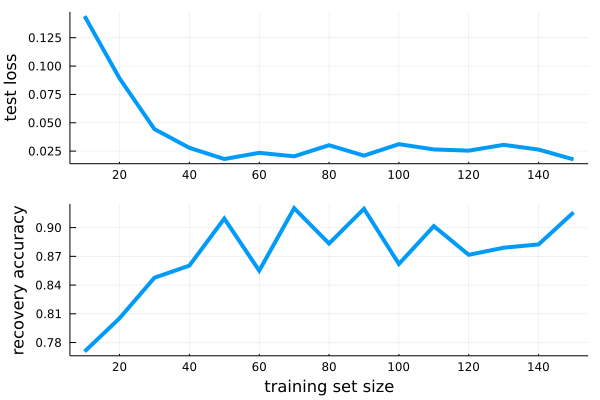

In [163]:
theme(:default, lw=4, label=nothing)

smallest = x -> [minimum(x[1:k]) for k in 1:length(x)]
biggest = x -> [maximum(x[1:k]) for k in 1:length(x)]
corr_hist = r -> [f̂'f / (norm(f̂)*norm(f)) for f̂ in r.f_hist]

# Plot correlation vs iteration
# plt1 = plot()
# for (num_train, r) in zip(train_set_sizes, results)
#     plot!(biggest(corr_hist(r)))
# end
# display(plt1)

# Plot best correlation vs train size
best_loss = r -> minimum(r.test_loss_hist)
best_recovery = r -> maximum(corr_hist(r))

plt21 = plot(train_set_sizes, median(best_loss.(results), dims=2))
plot!(ylabel="test loss")
plt22 = plot(train_set_sizes, median(best_recovery.(results), dims=2))
plot!(ylabel="recovery accuracy", xlabel="training set size")
plt = plot(plt21, plt22, layout=(2, 1))

savefig(plt, "perf_vs_dataset_size.png")
display(plt)

# Plot convergence for a single case

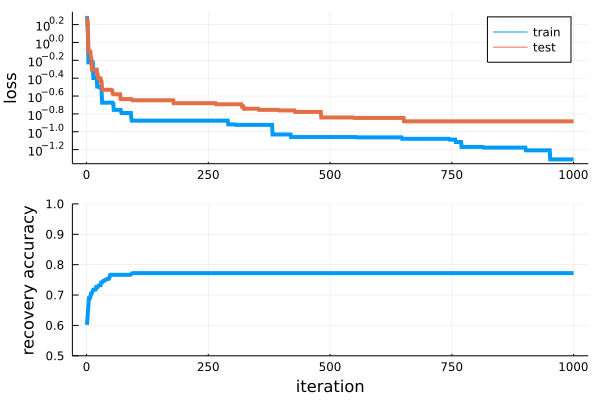

In [168]:
r = results[1, 1];

plt1 = plot(smallest(r.train_loss_hist), label="train")
plot!(smallest(r.test_loss_hist), label="test")
plot!(yscale=:log10, ylabel="loss")

plt2 = plot(biggest(corr_hist(r)), ylim=(0.5, 1.0))
plot!(xlabel="iteration", ylabel="recovery accuracy")

plt = plot(plt1, plt2, layout=(2, 1))

savefig(plt, "loss_small_dataset.png")
display(plt)

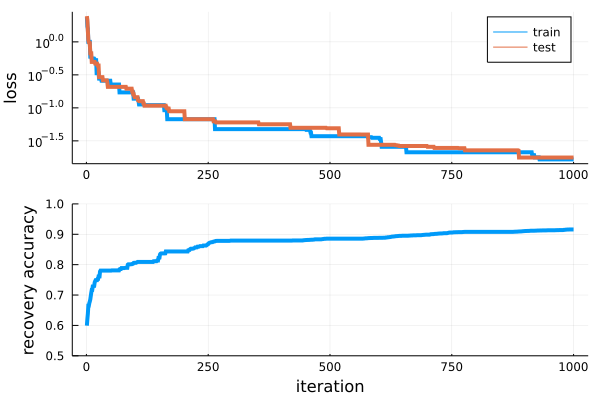

In [171]:
r = results[end, 2];

plt1 = plot(smallest(r.train_loss_hist), label="train")
plot!(smallest(r.test_loss_hist), label="test")
plot!(yscale=:log10, ylabel="loss")

plt2 = plot(biggest(corr_hist(r)), ylim=(0.5, 1.0))
plot!(xlabel="iteration", ylabel="recovery accuracy")

plt = plot(plt1, plt2, layout=(2, 1))

savefig(plt, "loss_large_dataset.png")
display(plt)

# Generation mix

In [156]:
case = test_cases[1]

opf_true = PowerManagementProblem(f, case.d, pmax, gmax, A)
solve!(opf_true, ECOS_QUIET)

opf_est = PowerManagementProblem(r.f̂, case.d, pmax, gmax, A)
solve!(opf_est, ECOS_QUIET);

norm(evaluate(opf_true.g) - evaluate(opf_est.g)) / norm(evaluate(opf_true.g)) = 0.019267860011189342


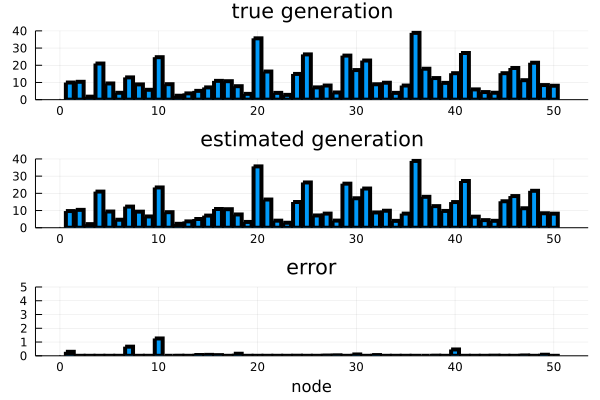

In [157]:
p1 = bar(evaluate(opf_true.g), title="true generation", ylim=(0, 40))
p2 = bar(evaluate(opf_est.g), title="estimated generation", ylim=(0, 40))
p3 = bar(evaluate(opf_true.g) - evaluate(opf_est.g), title="error", xlabel="node", 
    ylim=(0, 5))

@show norm(evaluate(opf_true.g) - evaluate(opf_est.g)) / norm(evaluate(opf_true.g))

plot(p1, p2, p3, layout=(3, 1))

# MEFs (true and estimated)

In [158]:
Random.seed!(52720)

c = rand(Exponential(2), n)
∇C = zeros(CarbonNetworks.kkt_dims(n, m))
∇C[1:n] = c

mefs_true = sensitivity_demand(opf_true, ∇C, (f, case.d, pmax, gmax, A))
mefs_est = sensitivity_demand(opf_est, ∇C, (r.f̂, case.d, pmax, gmax, A));

In [162]:
err = 0
n_cases = 200

for case in test_cases[1:n_cases]
    opf_true = PowerManagementProblem(f, case.d, pmax, gmax, A)
    solve!(opf_true, ECOS_QUIET)

    opf_est = PowerManagementProblem(r.f̂, case.d, pmax, gmax, A)
    solve!(opf_est, ECOS_QUIET);
    
    mefs_true = sensitivity_demand(opf_true, ∇C, (f, case.d, pmax, gmax, A))
    mefs_est = sensitivity_demand(opf_est, ∇C, (r.f̂, case.d, pmax, gmax, A));

    err += norm(mefs_true - mefs_est) / norm(mefs_true) / n_cases
end

@show err

err = 0.13302467407832927


0.13302467407832927

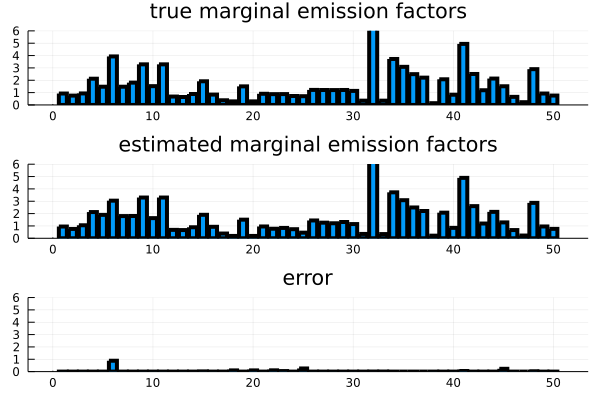

In [155]:
plot(
    bar(mefs_true, ylim=(0, 6), title="true marginal emission factors"),
    bar(mefs_est, ylim=(0, 6), title="estimated marginal emission factors"),
    bar(mefs_true - mefs_est, ylim=(0, 6), title="error"),
    layout=(3, 1)
)

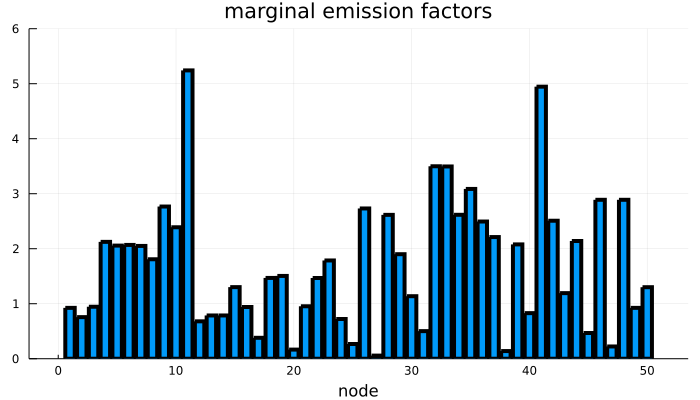

In [80]:
plt = bar(mefs_true, ylim=(0, 6), title="marginal emission factors", xlabel="node",
size=(700, 400))
savefig(plt, "opf_mefs.png")
display(plt)